In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from math import ceil

In [287]:
s = 'bacteria'  # Change this to 'bacteria', 'eukaryota', or 'viruses' as needed

count_matrix_path = f'../../dataset/uniprotkb_reference_proteomes/big_{s}_countmatrix.csv'
count_matrix = pd.read_csv(count_matrix_path, index_col=0)
print(f"Original matrix shape: {count_matrix.shape}")
count_matrix = count_matrix[count_matrix.sum(axis=1) > 0]
print(f"Filtered matrix shape (removed zero-sum rows): {count_matrix.shape}")

Original matrix shape: (9098, 14693)
Filtered matrix shape (removed zero-sum rows): (8360, 14693)


In [288]:
new_idx = [idx.split('_')[1] for idx in count_matrix.index]
count_matrix.index = new_idx

In [349]:
count_matrix

,PF00002,PF00004,PF00005,PF00006,PF00008,PF00009,PF00010,PF00011,PF00012,PF00013,...,PF25791,PF25792,PF25794,PF25796,PF25799,PF25800,PF25815,PF25816,PF25818,PF25819
1234679,0,6,95,5,0,9,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
312153,0,8,30,3,0,7,0,0,2,1,...,0,0,0,0,0,1,0,0,0,0
379731,0,13,58,4,0,9,0,2,3,1,...,0,0,0,0,0,2,0,0,0,0
369723,0,9,96,3,0,8,0,1,2,2,...,0,0,0,0,0,0,0,0,0,0
349521,0,13,91,9,0,9,0,2,5,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864201,0,11,38,3,0,7,0,2,3,2,...,0,0,0,0,0,0,0,0,0,0
2795293,0,13,52,4,0,8,0,5,3,2,...,0,0,0,0,0,0,0,0,0,0
2980174,0,3,9,4,0,5,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0
2839743,0,7,71,5,0,9,0,1,2,2,...,0,0,0,0,0,0,0,0,0,0


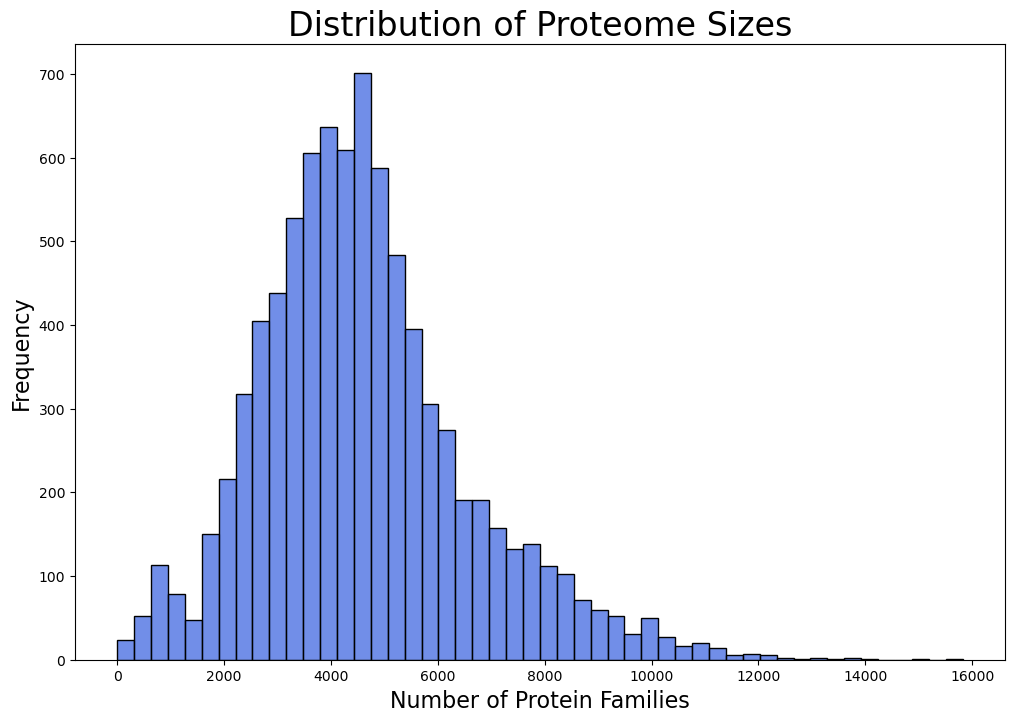

In [289]:
proteome_sizes = count_matrix.sum(axis=1)
plt.figure(figsize=(12, 8))
sns.histplot(proteome_sizes, bins=50, kde=False, color='royalblue')
plt.title('Distribution of Proteome Sizes', fontsize=24)
plt.xlabel('Number of Protein Families', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

Fitted Negative Binomial parameters: r=5.4076410907829695, p=0.00116940830441028


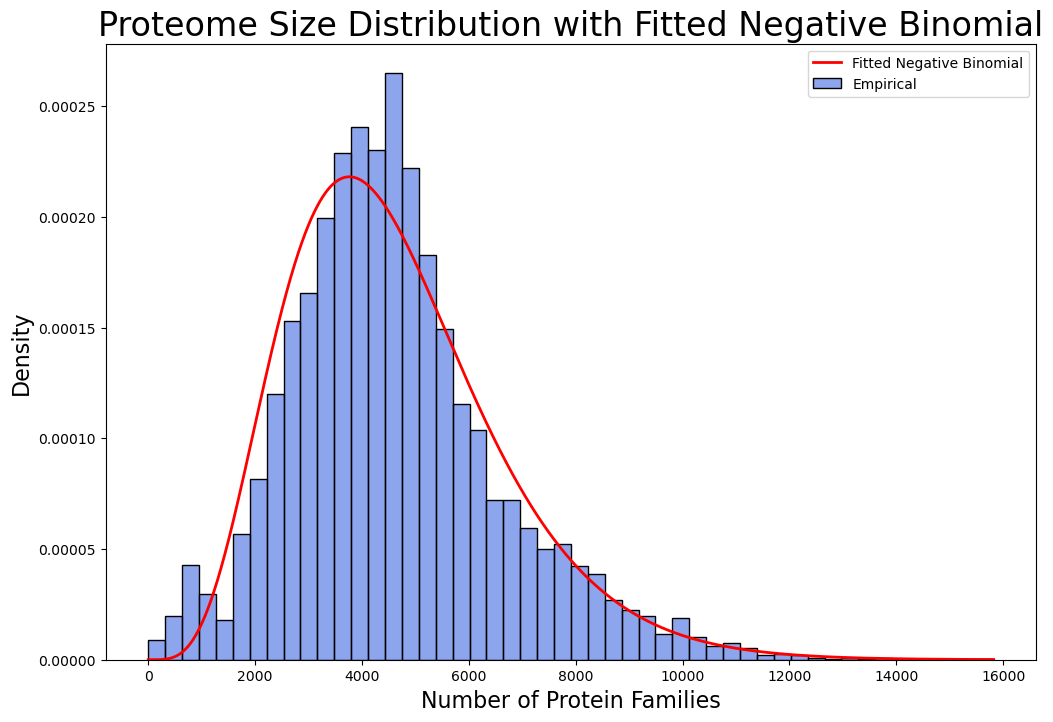

In [290]:
# fit a negative binomial distribution to the proteome sizes
from scipy.stats import nbinom
mean_size = proteome_sizes.mean()
var_size = proteome_sizes.var()
p = mean_size / var_size
r = mean_size * p / (1 - p)
print(f"Fitted Negative Binomial parameters: r={r}, p={p}")
x = np.arange(0, proteome_sizes.max())
pmf = nbinom.pmf(x, r, p)
plt.figure(figsize=(12, 8))
sns.histplot(proteome_sizes, bins=50, kde=False, color='royalblue', stat='density', label='Empirical', alpha=0.6)
plt.plot(x, pmf, 'r-', lw=2, label='Fitted Negative Binomial')
plt.title('Proteome Size Distribution with Fitted Negative Binomial', fontsize=24)
plt.xlabel('Number of Protein Families', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend()
plt.show()

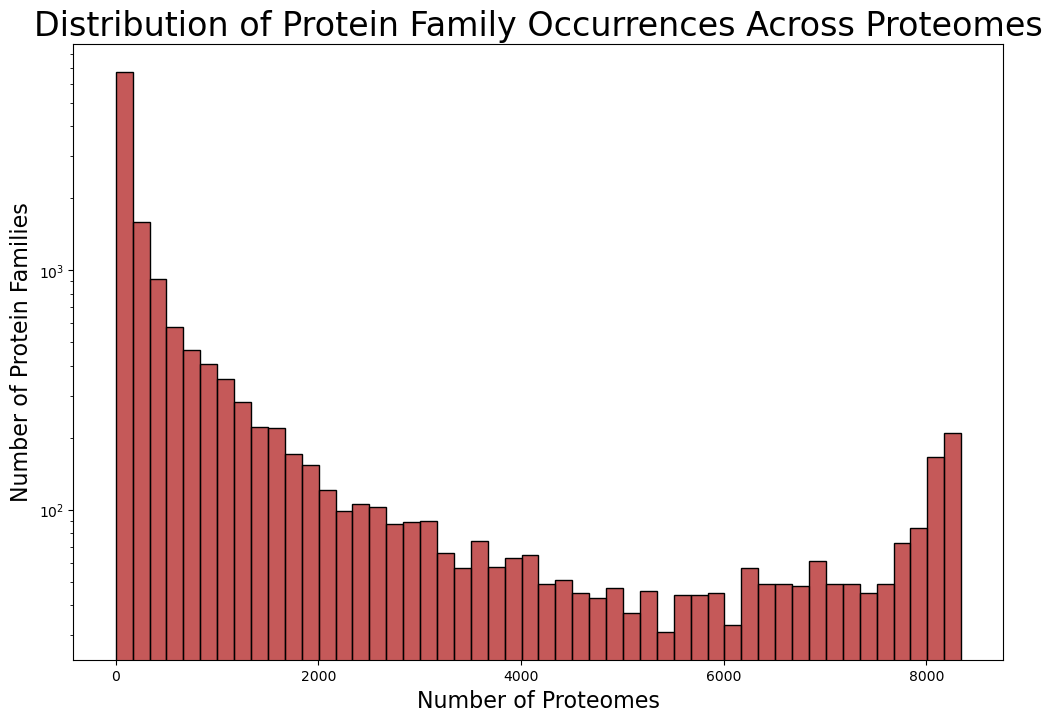

In [291]:
# for each protein family, count in how many proteomes it appears at least once
family_occurrences = (count_matrix > 0).sum(axis=0)
plt.figure(figsize=(12, 8))
sns.histplot(family_occurrences, bins=50, kde=False, color='firebrick')
plt.title('Distribution of Protein Family Occurrences Across Proteomes', fontsize=24)
plt.yscale('log')
plt.xlabel('Number of Proteomes', fontsize=16)
plt.ylabel('Number of Protein Families', fontsize=16)
plt.show()

_______________

In [292]:
thr_size = 1000
filtered_matrix = count_matrix[proteome_sizes >= thr_size]
print(f"Matrix shape after filtering proteomes with size >= {thr_size}: {filtered_matrix.shape}")

Matrix shape after filtering proteomes with size >= 1000: (8157, 14693)


In [293]:
normalized_matrix = filtered_matrix.div(filtered_matrix.sum(axis=1), axis=0)

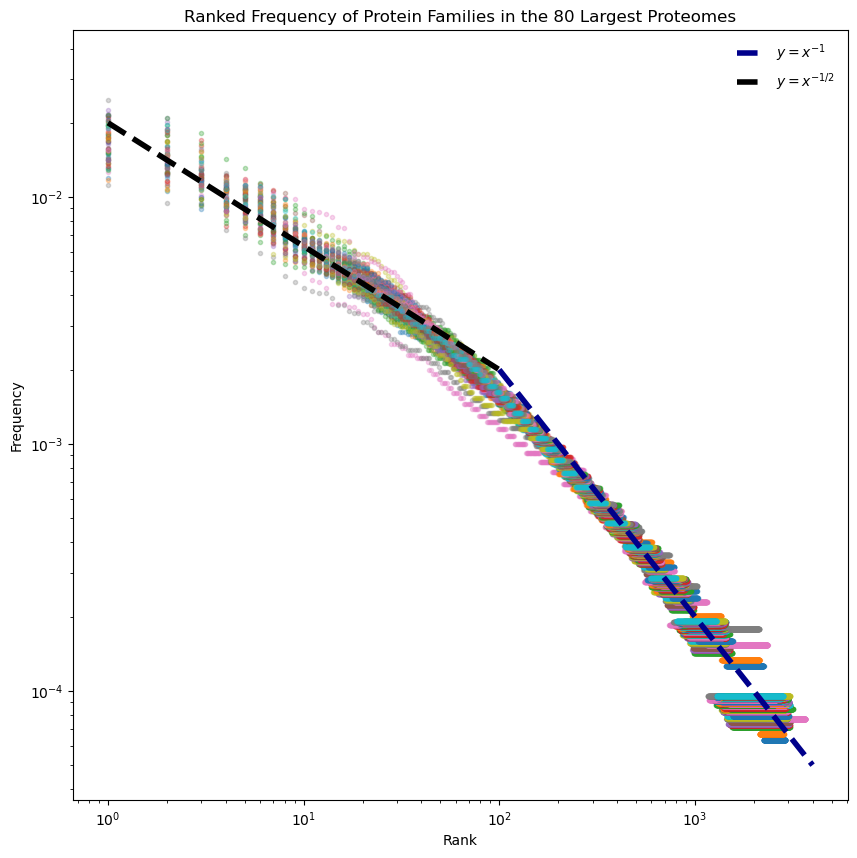

In [308]:
plt.figure(figsize=(10, 10))

l = 80  # how many largest proteomes to plot

common_idx = count_matrix.index.intersection(normalized_matrix.index)
proteome_sizes = count_matrix.loc[common_idx].sum(axis=1)
top_idx = proteome_sizes.nlargest(l).index

for tid in top_idx:
    row = normalized_matrix.loc[tid]
    ranked = np.sort(row[row > 0].to_numpy())[::-1]
    plt.loglog(ranked, marker='o', markersize=3, linestyle='None', alpha=0.3)

x1 = np.arange(100, 4000)
x2 = np.arange(1, 100)
y1 = 1/x1
y2 = 1/np.sqrt(x2)
k1 = 0.2
k2 = 0.02
plt.loglog(x1, k1*y1, linestyle='--', color='darkblue', label='$y=x^{-1}$', linewidth=4)
plt.loglog(x2, k2*y2, linestyle='--', color='black', label='$y=x^{-1/2}$', linewidth=4)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title(f'Ranked Frequency of Protein Families in the {l} Largest Proteomes')
plt.legend(markerscale=2.5, frameon=False)
plt.show()

/mnt/nvme_raid0/tmp/ipykernel_950323/2673081537.py:9: RuntimeWarning: divide by zero encountered in divide
  y2 = 1/np.sqrt(x2)


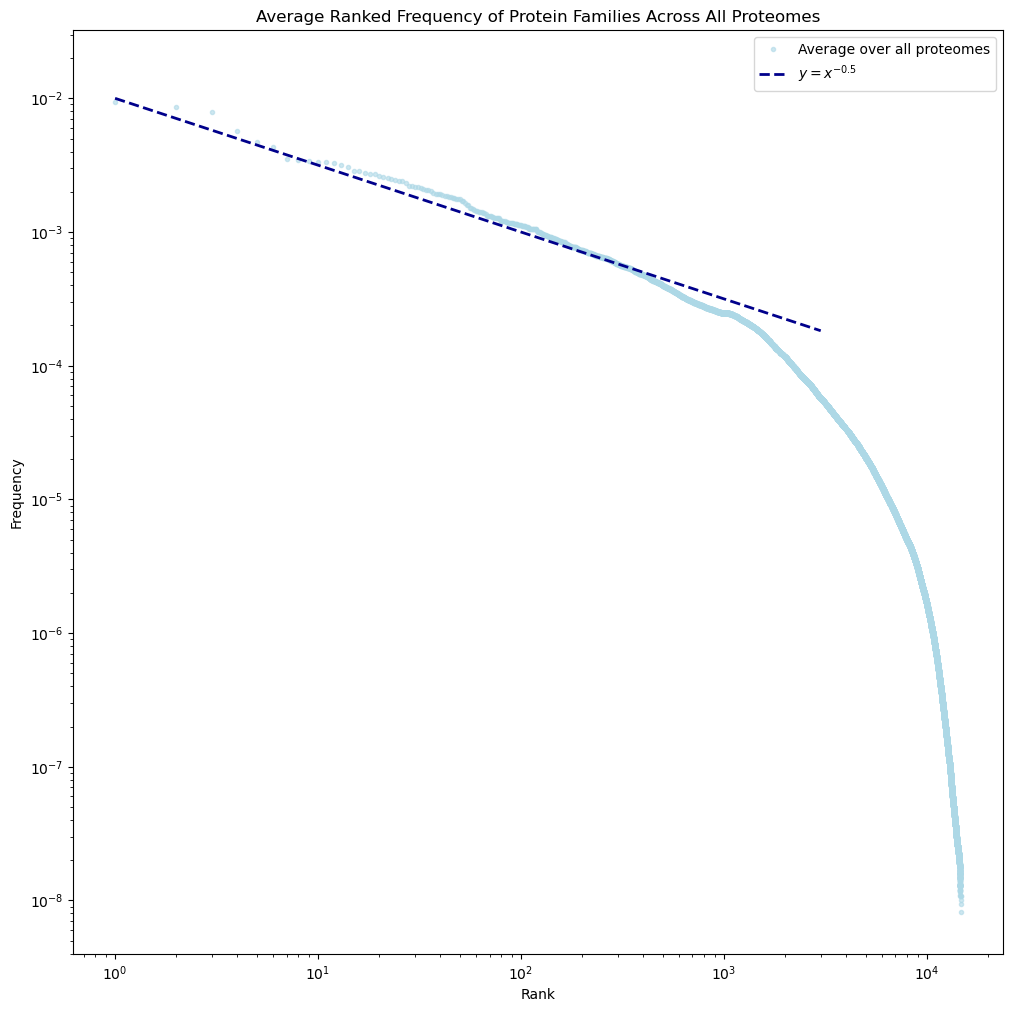

In [312]:
# plot the average zipf over all the proteomes
avg_freq = normalized_matrix.mean(axis=0)
ranked_avg = np.sort(avg_freq[avg_freq > 0])[::-1]
plt.figure(figsize=(12, 12))
plt.loglog(ranked_avg, marker='o', markersize=3, linestyle='None', alpha=0.6, color='lightblue', label='Average over all proteomes')
x1 = np.arange(1000, 10000)
x2 = np.arange(0, 3000)
y1 = 1/x1
y2 = 1/np.sqrt(x2)
k1=0.3
k2=0.01
#plt.loglog(x1, k1*y1, linestyle='--', color='grey', label='$y=x^{-1}$', linewidth=4)
plt.loglog(x2, k2*y2, linestyle='--', color='darkblue', label='$y=x^{-0.5}$', linewidth=2)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Average Ranked Frequency of Protein Families Across All Proteomes')
plt.legend()
plt.show()

"Groups" may refer to protein families or protein clans

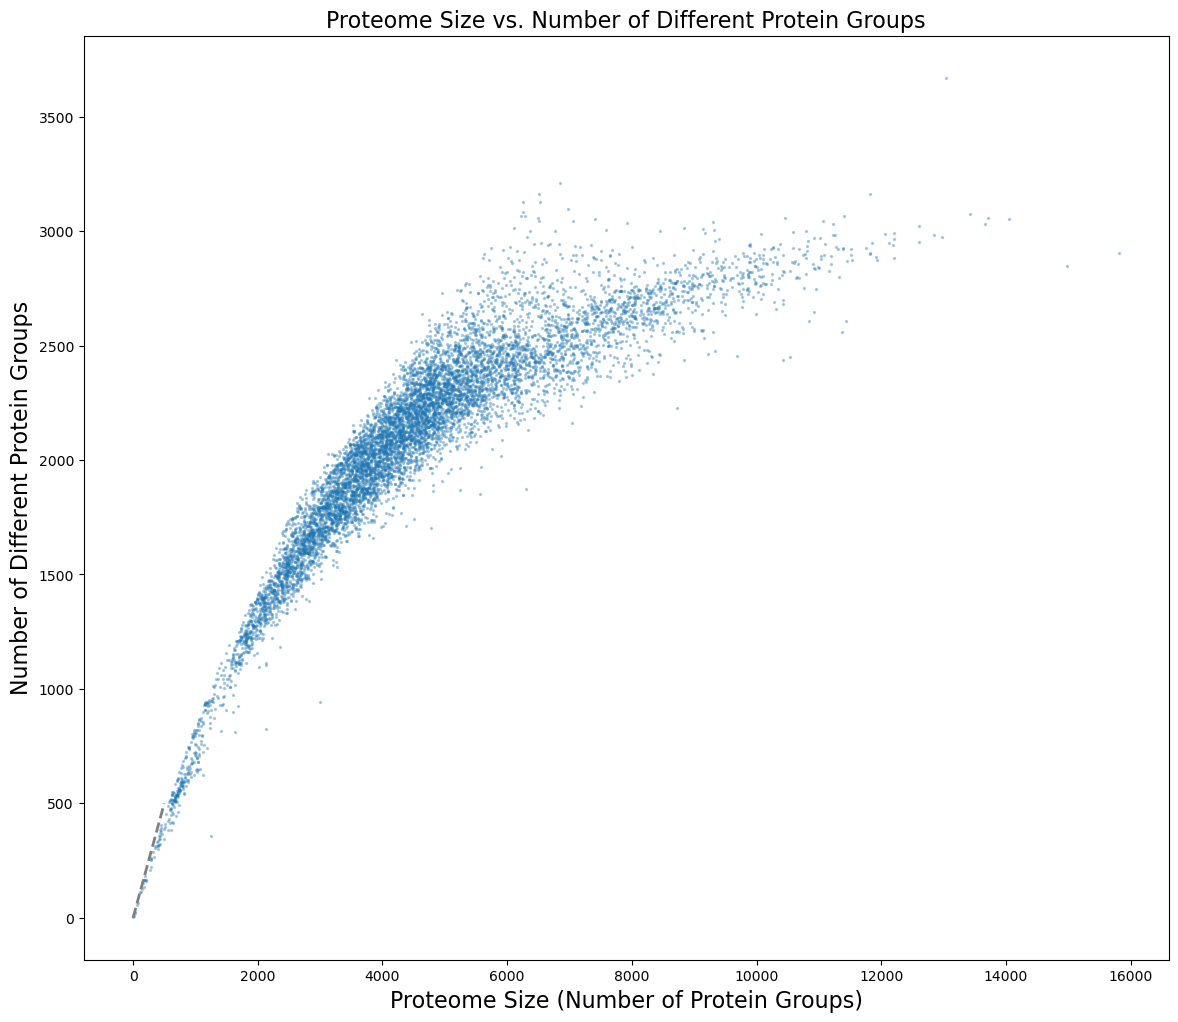

In [314]:
proteome_sizes = count_matrix.sum(axis=1)
n_different_families = (count_matrix > 0).sum(axis=1)
plt.figure(figsize=(14, 12))
x=np.arange(0, 500, 1)
y=x
plt.plot(x, y, linestyle='--', color='grey', label='$y=x$', linewidth=2)
plt.scatter(proteome_sizes, n_different_families, alpha=0.3, s=2)
plt.xlabel('Proteome Size (Number of Protein Groups)', fontsize=16)
plt.ylabel('Number of Different Protein Groups', fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.title('Proteome Size vs. Number of Different Protein Groups', fontsize=16)
plt.show()

______

## NCBI Taxonomy

In [9]:
taxid_to_name_path = '../../dataset/taxonomy_ncbi/taxid_to_name.tsv'
taxid_to_rank_path = '../../dataset/taxonomy_ncbi/taxid_to_rank.tsv'
taxid_to_parent_path = '../../dataset/taxonomy_ncbi/taxid_to_parent.names.ranks.tsv'

tid2nm = {}
with open(taxid_to_name_path, 'r') as f:
	for line in f:
		tid, name = line.strip().split('\t')
		tid2nm[int(tid)] = name
                
nm2tid = {v: k for k, v in tid2nm.items()}

tid2rk = {}
with open(taxid_to_rank_path, 'r') as f:
	for line in f:
		tid, rank = line.strip().split('\t')
		tid2rk[int(tid)] = rank

In [10]:
tree = nx.Graph()
tree_dir = nx.DiGraph()

with open(taxid_to_parent_path, 'r') as f:
    for line in f:
        node_tid, node_rank, node_name, parent_tid, parent_rank, parent_name = line.rstrip('\n').split('\t')

        # normalize ids (keep as strings or cast to int consistently)
        node_tid = int(node_tid)
        parent_tid = int(parent_tid)

        # add nodes with attributes
        tree.add_node(node_tid, name=node_name.strip(), rank=node_rank.strip())
        tree_dir.add_node(node_tid, name=node_name.strip(), rank=node_rank.strip())
        tree.add_node(parent_tid, name=parent_name.strip(), rank=parent_rank.strip())
        tree_dir.add_node(parent_tid, name=parent_name.strip(), rank=parent_rank.strip())

        # parent -> child
        tree.add_edge(parent_tid, node_tid)
        tree_dir.add_edge(parent_tid, node_tid)

tree.remove_edge(1, 1)
tree_dir.remove_edge(1, 1)

print(f'Number of connected components in the tree: {nx.number_connected_components(tree)}')
print(f'Number of weakly connected components in the directed tree: {nx.number_weakly_connected_components(tree_dir)}')

print(f'Number of nodes in the tree: {tree.number_of_nodes()}')
print(f'Number of edges in the tree: {tree.number_of_edges()}')

Number of connected components in the tree: 1
Number of weakly connected components in the directed tree: 1
Number of nodes in the tree: 2703951
Number of edges in the tree: 2703950


__________________

## Colored Heaps' curve

In [341]:
count_matrix.index = count_matrix.index.astype(int)

parent_of = {}
rank_of   = {}
name_of   = {}

for n, data in tree_dir.nodes(data=True):
    rank_of[n] = data.get('rank', '').lower()
    name_of[n] = data.get('name', str(n))

for u, v in tree_dir.edges():
    parent_of[v] = u  # parent -> child edges

def lineage(tid):
    """Yield tid, then its ancestors up to the ultimate root (inclusive)."""
    cur = tid
    seen = set()
    while cur is not None and cur not in seen:
        yield cur
        seen.add(cur)
        cur = parent_of.get(cur, None)

def ancestor_at_rank(tid, target_rank):
    """Return (ancestor_tid, name) at the requested rank; (None, 'Unknown') if not found."""
    target_rank = target_rank.lower()
    for a in lineage(tid):
        if rank_of.get(a, '').lower() == target_rank:
            return a, name_of.get(a, str(a))
    return None, 'Unknown'

def first_child_under_root(tid, root_tid):
    """
    Return the *first node below root_tid* on the path from root -> tid.
    If tid is not under root_tid, return (None, 'Outside root').
    """
    # ascend tid to root, collecting path
    path_up = list(lineage(tid))  # tid -> ... -> root
    if root_tid not in path_up:
        return None, 'Outside root'
    # path_up is bottom-up; find the node whose parent is root_tid
    for node in path_up:
        if parent_of.get(node, None) == root_tid:
            return node, name_of.get(node, str(node))
    # If tid == root_tid, treat it as its own clade
    if tid == root_tid:
        return tid, name_of.get(tid, str(tid))
    return None, 'Outside root'

In [342]:
available_ranks = set(tid2rk.values())
print(f'Available ranks in the taxonomy: {sorted(available_ranks)}')

Available ranks in the taxonomy: ['acellular root', 'biotype', 'cellular root', 'clade', 'class', 'cohort', 'domain', 'family', 'forma', 'forma specialis', 'genotype', 'genus', 'infraclass', 'infraorder', 'isolate', 'kingdom', 'morph', 'no rank', 'order', 'parvorder', 'pathogroup', 'phylum', 'realm', 'section', 'series', 'serogroup', 'serotype', 'species', 'species group', 'species subgroup', 'strain', 'subclass', 'subcohort', 'subfamily', 'subgenus', 'subkingdom', 'suborder', 'subphylum', 'subsection', 'subspecies', 'subtribe', 'subvariety', 'superclass', 'superfamily', 'superorder', 'superphylum', 'tribe', 'varietas']


In [377]:
TARGET_RANK = 'infraorder'   # examples: 'superkingdom', 'kingdom', 'phylum', 'class', 'order', ...

# Map each TaxID to the ancestor at that rank
taxids = count_matrix.index.tolist()

clade_id = []
clade_label = []
for tid in taxids:
    a_tid, a_name = ancestor_at_rank(tid, TARGET_RANK)
    clade_id.append(a_tid if a_tid is not None else -1)
    clade_label.append(a_name)

clade_series = pd.Series(clade_label, index=count_matrix.index, name=f'{TARGET_RANK}_clade')
clade_series


1234679    Unknown
312153     Unknown
379731     Unknown
369723     Unknown
349521     Unknown
            ...   
2864201    Unknown
2795293    Unknown
2980174    Unknown
2839743    Unknown
472978     Unknown
Name: infraorder_clade, Length: 8360, dtype: object

In [367]:
# ROOT_TID = 2  # e.g., Bacteria

# clade_id = []
# clade_label = []
# for tid in count_matrix.index:
#     c_tid, c_name = first_child_under_root(tid, ROOT_TID)
#     clade_id.append(c_tid if c_tid is not None else -1)
#     clade_label.append(c_name)

# clade_series = pd.Series(clade_label, index=count_matrix.index, name=f'child_of_{ROOT_TID}')

In [368]:
# remove: "Bacteria incertae sedis", "Outside root", "unclassified Bacteria" and "delta/epsilon subdivisions"
valid_labels = set(clade_series.unique()) - {"Bacteria incertae sedis", "Outside root", "unclassified Bacteria", "delta/epsilon subdivisions"}
clade_series = clade_series[clade_series.isin(valid_labels)]
count_matrix = count_matrix.loc[clade_series.index]
print(f"Matrix shape after filtering by valid clades: {count_matrix.shape}")

Matrix shape after filtering by valid clades: (8360, 14693)


In [372]:
save_pictures = True  # Set to False if you do not want to save figures

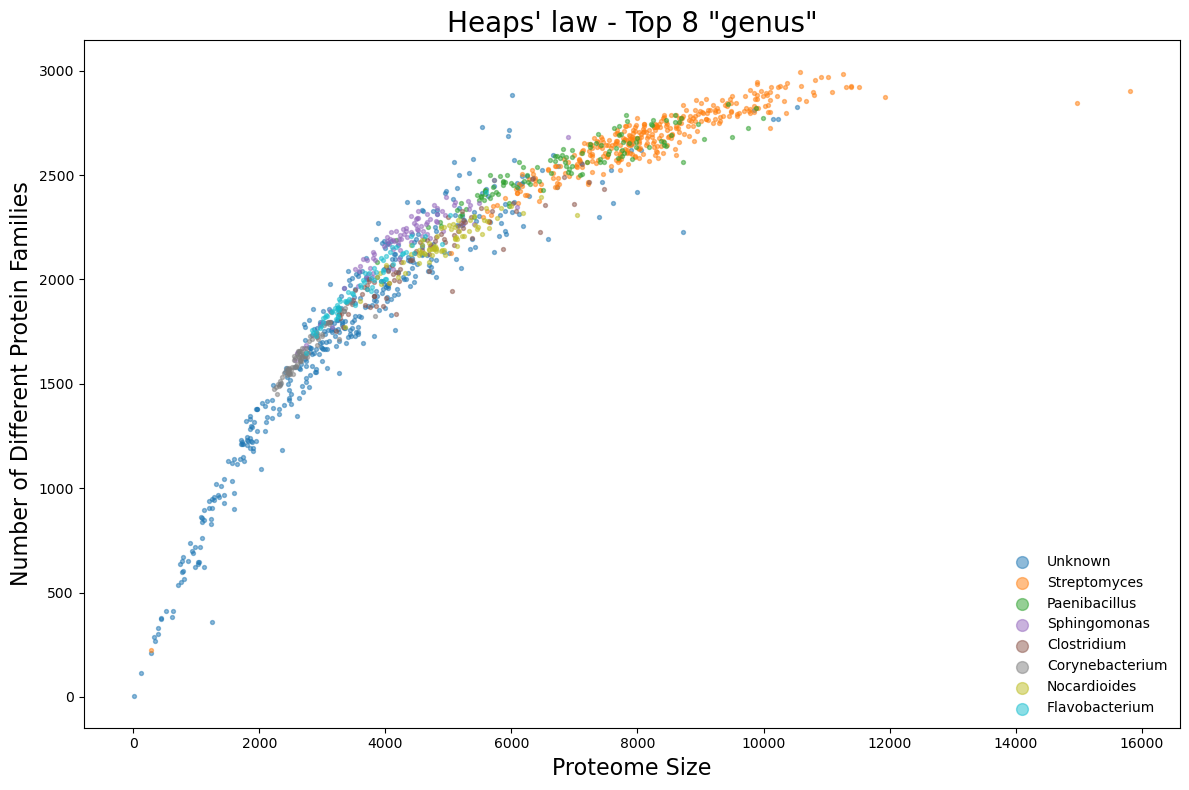

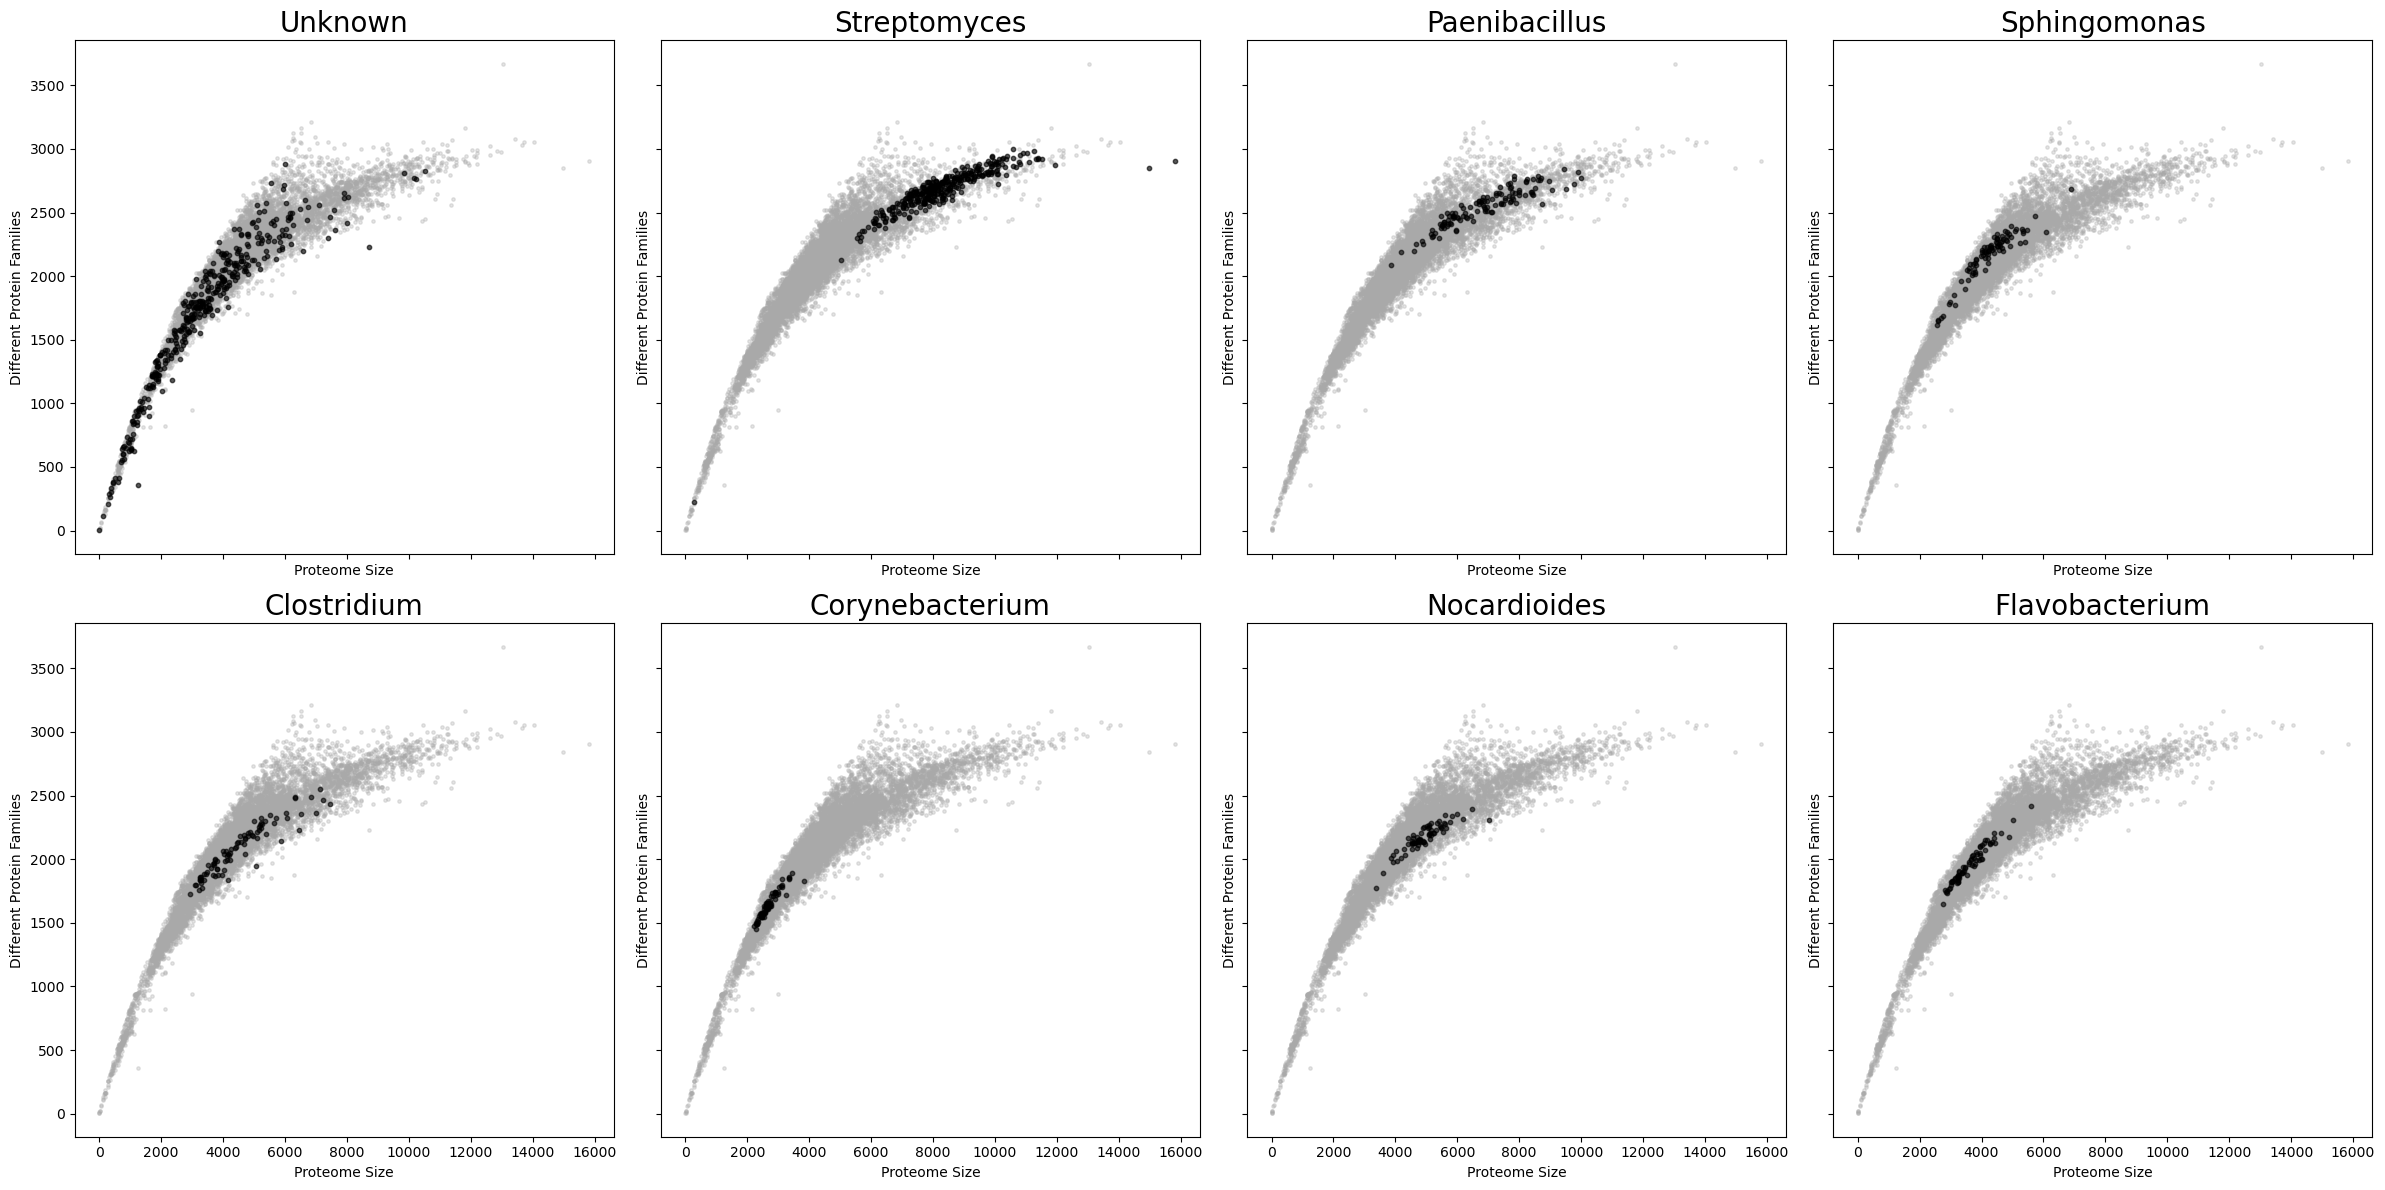

In [373]:
proteome_sizes = count_matrix.sum(axis=1)
n_different_families = (count_matrix > 0).sum(axis=1)

df = pd.DataFrame({
    'size': proteome_sizes,
    'richness': n_different_families,
    'clade': clade_series
}).dropna()

K = 8
top_clades = df['clade'].value_counts().head(K).index.tolist()

# consistent color map for the top K (keep order by frequency)
cmap = plt.get_cmap('tab10', len(top_clades))
clade_color = {cl: cmap(i) for i, cl in enumerate(top_clades)}

# 1) COMBINED PLOT: only top-K clades (no "Other")
df_top = df[df['clade'].isin(top_clades)].copy()

plt.figure(figsize=(12, 8))
# optional 1:1 guide
# x = np.linspace(0, df['size'].max()*1.05, 200)
# plt.plot(x, x, linestyle='--', color='grey', linewidth=1, alpha=0.6)

for cl in top_clades:
    sub = df_top[df_top['clade'] == cl]
    plt.scatter(sub['size'], sub['richness'], s=8, alpha=0.5, label=cl, c=[clade_color[cl]])

plt.xlabel('Proteome Size', fontsize=16)
plt.ylabel('Number of Different Protein Families', fontsize=16)
plt.title(f'Heaps\' law - Top {K} "{TARGET_RANK}"', fontsize=20)
plt.legend(markerscale=3, frameon=False, loc='lower right')
plt.tight_layout()
if save_pictures:
    plt.savefig(f'../pictures/heaps_top{K}_{TARGET_RANK}.svg')
    plt.savefig(f'../pictures/heaps_top{K}_{TARGET_RANK}.png')
plt.show()

# 2) FACETED PLOTS: one Heaps per clade; target clade colored, all others grey
# layout: up to 4 columns
cols = min(K, 4)
rows = ceil(K / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

# Precompute the grey background once
bg_x = df['size'].to_numpy()
bg_y = df['richness'].to_numpy()

for i, cl in enumerate(top_clades):
    ax = axes[i]
    # background: everyone grey (including non-top-K)
    ax.scatter(bg_x, bg_y, s=6, alpha=0.3, color='darkgrey')

    # highlight the clade in color
    sub = df[df['clade'] == cl]
    ax.scatter(sub['size'], sub['richness'], s=10, alpha=0.6, c='black', label=cl)

    # optional 1:1 guide
    # x = np.linspace(0, df['size'].max()*1.05, 200)
    # ax.plot(x, x, linestyle='--', color='grey', linewidth=1, alpha=0.6)

    ax.set_title(cl, fontsize=20)
    ax.set_xlabel('Proteome Size')
    ax.set_ylabel('Different Protein Families')
    #ax.legend(frameon=False, loc='lower right')

# hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

#fig.suptitle(f'Per-clade Heaps — highlight each of the top {K} clades', y=0.995)
plt.tight_layout()
if save_pictures:
    plt.savefig(f'../pictures/heaps_facet_top{K}_{TARGET_RANK}.svg', format='svg')
    plt.savefig(f'../pictures/heaps_facet_top{K}_{TARGET_RANK}.png', format='png')	
plt.show()
